In [22]:
import json
import numpy as np
import pandas as pd
import matplotlib

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter


In [4]:
data_dir = '/home/diwu/ralm/self-rag/data_creation/'

gen_data = [json.loads(line) for line in open(data_dir + '/generator_training_data_full_output_1005.jsonl').readlines()]
critic_data = json.load(open(data_dir + '/critic_training_data_gpt4_reward_all_0813_train.json'))

In [5]:
critic_tasks = set([x['task'] for x in critic_data])
critic_task2data = {t: [x for x in critic_data if x['task'] == t] for t in critic_tasks} 

In [27]:
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer, util
import numpy as np
from typing import List, Tuple

def jaccard_similarity(str1: str, str2: str) -> float:
    """Calculate the Jaccard Similarity between two strings."""
    set1 = set(str1.split())
    set2 = set(str2.split())
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    return len(intersection) / len(union)

def cosine_similarity_with_embedding(documents: List[str], query: str) -> List[Tuple[str, float]]:
    """Calculate cosine similarity using sentence transformer embeddings."""
    model = SentenceTransformer('all-mpnet-base-v2')
    doc_embeddings = model.encode(documents)
    query_embedding = model.encode(query)
    print(doc_embeddings.shape, query_embedding.shape)
    similarities = util.cos_sim(query_embedding, doc_embeddings).squeeze()
    # similarities = cosine_similarity(query_embedding, doc_embeddings).flatten()
    return [(documents[i], similarities[i]) for i in range(len(documents))]

# def top_k_similar_strings(strings: List[str], query: str, k: int, similarity_func) -> List[Tuple[str, float]]:
#     """Return top-k most similar strings based on a similarity function."""
#     similarities = [(string, similarity_func(query, string)) for string in strings]
#     sorted_similarities = sorted(similarities, key=lambda x: x[1], reverse=True)
#     return sorted_similarities[:k]

def top_k_similar_strings(strings: List[str], query: str, k: int, similarity_func) -> List[Tuple[str, float]]:
    """Return top-k most similar strings based on a similarity function."""
    similarities = similarity_func(strings, query)
    sorted_similarities = sorted(similarities, key=lambda x: x[1], reverse=True)
    return sorted_similarities[:k]


# Example usage
inst2entry = {x['input']: x for x in critic_task2data['retrieval']}
strings = [x['input'] for x in critic_task2data['retrieval']]
query = '### Instruction:\nQuestion: Tell me a bio of {entity}.\n\n### Response:\n'
k = 20

# Jaccard similarity
# top_k_jaccard = top_k_similar_strings(strings, query, k, jaccard_similarity)
# print(top_k_jaccard)

# # Cosine similarity (this might take a bit longer due to model loading and embedding computation)
top_k_cosine = top_k_similar_strings(strings, query, k, cosine_similarity_with_embedding)
# print(strings)


(4798, 768) (768,)


In [29]:
[inst2entry[x[0]] for x in top_k_cosine]

[{'instruction': 'When provided with instruction, please evaluate whether seeking additional information from external sources such as the web (e.g., Wikipedia) aids in producing a more comprehensive response. Respond with either [Retrieval] or [No Retrieval].',
  'input': 'Task instruction: Research about a famous scientist and provide a short biography about him/her.\n',
  'output': '[Retrieval]',
  'task': 'retrieval'},
 {'instruction': 'When provided with instruction, please evaluate whether seeking additional information from external sources such as the web (e.g., Wikipedia) aids in producing a more comprehensive response. Respond with either [Retrieval] or [No Retrieval].',
  'input': 'Task instruction: Describe the contents of the given Wikipedia article in one sentence. https://en.wikipedia.org/wiki/Data_visualization\n',
  'output': '[Retrieval]',
  'task': 'retrieval'},
 {'instruction': 'When provided with instruction, please evaluate whether seeking additional information f

In [6]:
probs = [float(line.strip()) for line in open('/home/diwu/ralm/self-rag/analysis/critic_data_selective_probs_selfrag-7b.txt').readlines()]
len(probs)
entries = list(zip(probs, critic_task2data['retrieval']))


In [21]:

retrieval_entries = [x for x in entries if x[1]['output'] == '[Retrieval]']
no_retrieval_entries = [x for x in entries if x[1]['output'] == '[No Retrieval]']
 
print('T\tP\tR\tF1')
for threshold in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    precision_count, precision_all = 0, 0
    recall_count, recall_all = 0, 0
    for score, entry in entries:
        if entry['output'] == '[Retrieval]':
            recall_all += 1
            if score > threshold:
                recall_count += 1
        if score > threshold:
            precision_all += 1
            if entry['output'] == '[Retrieval]':
                precision_count += 1

    precision = precision_count / precision_all if precision_all != 0 else 0
    recall = recall_count / recall_all if recall_all != 0 else 0
    f1 = ((2 * precision * recall) / (precision + recall)) if precision * recall != 0 else 0 
    
    # no_retrieval_acc = len([x for x in no_retrieval_entries if x[0] <= threshold]) / len(no_retrieval_entries)
    # retrieval_acc = len([x for x in retrieval_entries if x[0] > threshold]) / len(retrieval_entries)
    # print('{} {:.04f} {:.04f}'.format(threshold, no_retrieval_acc, retrieval_acc))

    
    print('{}\t{:.04f}\t{:.04f}\t{:.04f}'.format(threshold, precision, recall, f1))

T	P	R	F1
0.1	0.4927	0.9983	0.6598
0.2	0.4872	0.9768	0.6502
0.3	0.4527	0.8487	0.5904
0.4	0.3411	0.5199	0.4119
0.5	0.1571	0.1509	0.1539
0.6	0.0458	0.0173	0.0251
0.7	0.0320	0.0017	0.0032
0.8	0.0000	0.0000	0.0000
0.9	0.0000	0.0000	0.0000


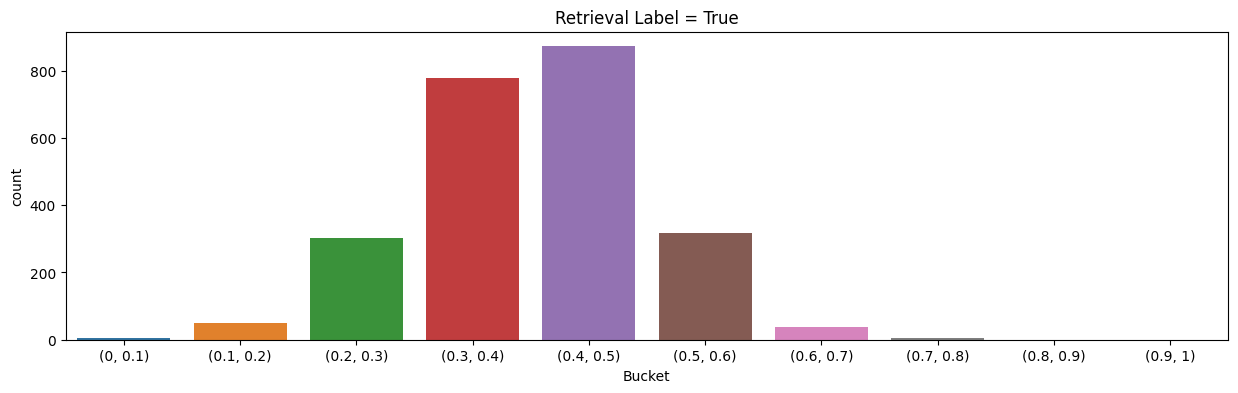

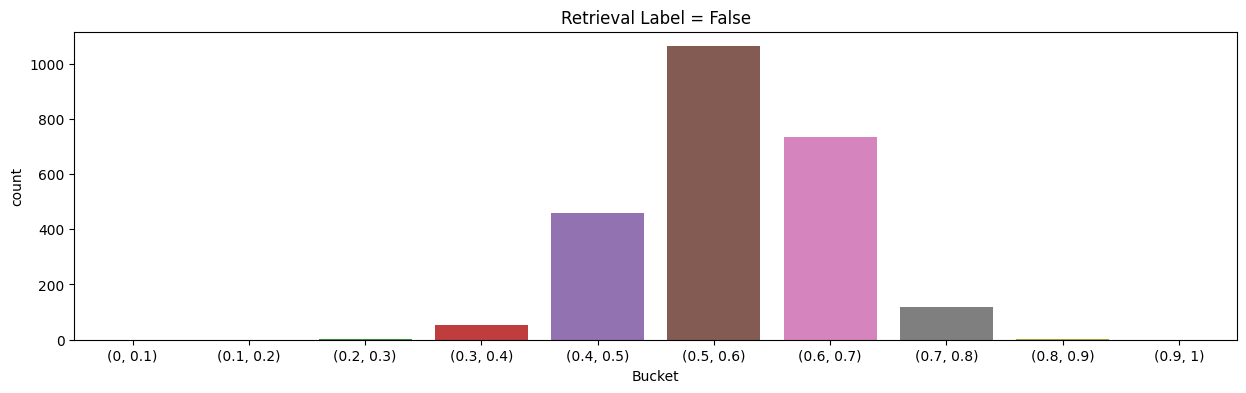

In [26]:
# group into buckets
def plot_score_distribution_v3(values, ranges, exp_name, out_dir):
    def bucket_value(val, ranges):
        try:
            _ = ranges[0]
            for start, end in ranges:
                if start <= val < end:
                    if end == -0.01:
                        return f"({start}, 0)"
                    if start == -0.01:
                        return "0"
                    if start == 0.01:
                        return f"(0, {end})"
                    return f"({start}, {end})"
            return f"({end}+)"
        except:
            for x in ranges:
                if x == val:
                    return f"{x}"
            return "others"

    df = pd.DataFrame(values, columns=["Value"])
    df["Bucket"] = df["Value"].apply(bucket_value, ranges=ranges)

    try:
        order = [f"({start}, {end})" for start, end in ranges] # + [f"({ranges[-1][1]}+)"]
    except:
        order = [f"{x}" for x in ranges] + ["others"]

    order_corrected = []
    for start, end in ranges:
        if end == -0.01:
            order_corrected.append(f"({start}, 0)")
        elif start == -0.01:
            order_corrected.append("0")
        elif start == 0.01:
            order_corrected.append(f"(0, {end})")
        else:
            order_corrected.append(f"({start}, {end})")

    plt.figure(figsize=(15, 4))
    sns.countplot(data=df, x="Bucket", order=order_corrected)
    plt.title(exp_name)
    plt.show()

plot_score_distribution_v3([x[0] for x in retrieval_entries],
                           [(0, 0.1), (0.1, 0.2), (0.2, 0.3), (0.3, 0.4), (0.4, 0.5), (0.5, 0.6), (0.6, 0.7), (0.7, 0.8), (0.8, 0.9), (0.9, 1)], 
                           'Retrieval Label = True', "")
plot_score_distribution_v3([x[0] for x in no_retrieval_entries],
                           [(0, 0.1), (0.1, 0.2), (0.2, 0.3), (0.3, 0.4), (0.4, 0.5), (0.5, 0.6), (0.6, 0.7), (0.7, 0.8), (0.8, 0.9), (0.9, 1)], 
                           'Retrieval Label = False', "")